In [67]:
import pandas as pd
import json

%matplotlib inline
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [236]:
from approved_venders import get_approved_venders, get_arizona_listings
from approved_venders import get_listings_near, batch_listings_near, batch_arizona_listings

### vender information

In [26]:
venders = pd.DataFrame(json.loads(get_approved_venders())['bundle'])
venders.to_csv('../../data/Approved_Vendors.csv')

In [31]:
venders.activeListings.describe()

count        5.000000
mean     16702.800000
std      16288.408323
min          0.000000
25%        196.000000
50%      20701.000000
75%      25514.000000
max      37103.000000
Name: activeListings, dtype: float64

In [76]:
mesa_df = pd.DataFrame(json.loads(get_listings_near(offset=0))['bundle'])
#venders.to_csv('../../data/Approved_Vendors.csv')

In [81]:
mesa_list = batch_listings_near()
mesa_df = pd.concat(mesa_list, axis=0)
mesa_df.to_csv('../../data/city_mesa_df.csv')

Running job 1, last job had 100 listings
Running job 2, last job had 100 listings
Running job 3, last job had 100 listings
Running job 4, last job had 100 listings
Running job 5, last job had 100 listings
Running job 6, last job had 100 listings
Running job 7, last job had 100 listings
Running job 8, last job had 100 listings
Running job 9, last job had 100 listings
Running job 10, last job had 100 listings
Running job 11, last job had 100 listings
Running job 12, last job had 100 listings
Running job 13, last job had 100 listings
Running job 14, last job had 100 listings
Running job 15, last job had 100 listings
Running job 16, last job had 100 listings
Running job 17, last job had 100 listings
Running job 18, last job had 100 listings
Running job 19, last job had 100 listings
Running job 20, last job had 100 listings
Running job 21, last job had 100 listings
Running job 22, last job had 100 listings
Running job 23, last job had 100 listings
Running job 24, last job had 57 listings


In [226]:
phoenix_list = get_arizona_listings("phoenix")
phoenix_df = pd.concat(phoenix_list, axis=0)
phoenix_df.to_csv('../../data/city_phoenix_df.csv')

Running job 1, last job had 100 listings
Running job 2, last job had 100 listings
Running job 3, last job had 100 listings
Running job 4, last job had 100 listings
Running job 5, last job had 100 listings
Running job 6, last job had 100 listings
Running job 7, last job had 100 listings
Running job 8, last job had 100 listings
Running job 9, last job had 100 listings
Running job 10, last job had 100 listings
Running job 11, last job had 100 listings
Running job 12, last job had 100 listings
Running job 13, last job had 100 listings
Running job 14, last job had 100 listings
Running job 15, last job had 100 listings
Running job 16, last job had 100 listings
Running job 17, last job had 100 listings
Running job 18, last job had 100 listings
Running job 19, last job had 100 listings
Running job 20, last job had 100 listings
Running job 21, last job had 100 listings
Running job 22, last job had 100 listings
Running job 23, last job had 100 listings
Running job 24, last job had 100 listings
R

### Get AZ Listings

In [262]:
az_list = batch_arizona_listings()
az_df = pd.concat(az_list2, axis=0)
az_df.to_csv('../../data/az_df.csv')

Running job 1, last job had 100 listings
Running job 2, last job had 100 listings
Running job 3, last job had 100 listings
Running job 4, last job had 100 listings
Running job 5, last job had 100 listings


In [248]:
import matplotlib
matplotlib.style.use('ggplot')

In [252]:
c = ['baths',
'bedrooms',
'acres',
'squareFootage',
'closePrice',
'daysOnMarket',
'originalPrice',
'price',
'yearBuilt']

In [266]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


In [ ]:
df = az_df[(np.abs(stats.zscore(az_df)) < 3).all(axis=1)]

AZ 54000+ Listings


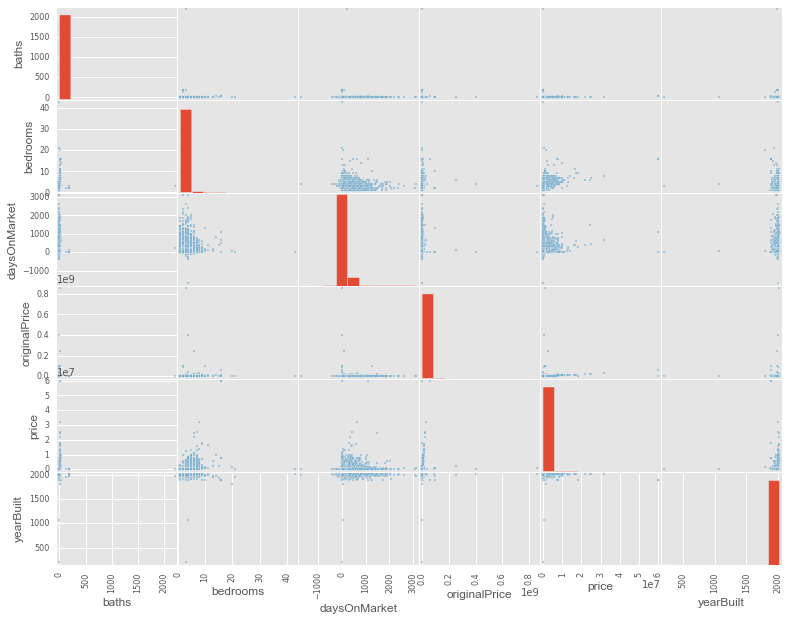

In [254]:
pd.scatter_matrix(az_df[c], figsize=(13, 10))
print('AZ 54000+ Listings')

In [257]:
az_df.to_csv('../../data/az_df.csv')

In [133]:
mesa_df.city.value_counts()

Mesa          1647
Gilbert        309
Tempe          250
Chandler        97
Scottsdale      54
Name: city, dtype: int64

In [218]:
m = mesa_df.dropna(axis=1, how='all')

count        833
unique       401
top       160000
freq          16
Name: closePrice, dtype: float64

In [225]:
m.closePrice.dropna().astype(int).describe()

count        833.000000
mean      176221.392557
std       103486.168275
min        23500.000000
25%       110000.000000
50%       159900.000000
75%       220000.000000
max      1100000.000000
Name: closePrice, dtype: float64

In [140]:
(mesa_df.closePrice - mesa_df.originalPrice)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
       ...  
27    -59000
28   -132000
29   -105000
30   -135000
31    -59900
32    -59900
33    -40900
34    -70900
35    -33000
36   -124900
37    -64900
38     35630
39    -58000
40    -51900
41    -34900
42    -90000
43    -34000
44    -44999
45    -70000
46    -85000
47   -555000
48       NaN
49    -38500
50    -89900
51       NaN
52     -7900
53    -10430
54       NaN
55     10100
56      6500
dtype: object

In [187]:
dt = pd.DatetimeIndex(pd.to_datetime(mesa_df.listDate.astype('datetime64[s]'), infer_datetime_format=True).values)


In [193]:
s = pd.Series(1, index=dt)
s.resample('D', how='sum').fillna(0)

2005-03-17     1
2005-03-18     0
2005-03-19     0
2005-03-20     0
2005-03-21     0
2005-03-22     0
2005-03-23     0
2005-03-24     0
2005-03-25     0
2005-03-26     0
2005-03-27     0
2005-03-28     0
2005-03-29     0
2005-03-30     0
2005-03-31     0
2005-04-01     0
2005-04-02     0
2005-04-03     0
2005-04-04     0
2005-04-05     1
2005-04-06     0
2005-04-07     0
2005-04-08     0
2005-04-09     0
2005-04-10     0
2005-04-11     0
2005-04-12     0
2005-04-13     0
2005-04-14     0
2005-04-15     0
              ..
2015-10-09    21
2015-10-10     7
2015-10-11    10
2015-10-12    25
2015-10-13     7
2015-10-14    16
2015-10-15    23
2015-10-16    23
2015-10-17     9
2015-10-18     5
2015-10-19     8
2015-10-20    16
2015-10-21    13
2015-10-22    18
2015-10-23    17
2015-10-24    14
2015-10-25     3
2015-10-26    11
2015-10-27    14
2015-10-28    15
2015-10-29    19
2015-10-30    19
2015-10-31    10
2015-11-01     4
2015-11-02    17
2015-11-03    11
2015-11-04    14
2015-11-05    

In [194]:
# s.resample('D', how='sum').plot()

In [198]:
s.resample('D', how='sum').fillna(0)

2005-03-17     1
2005-03-18     0
2005-03-19     0
2005-03-20     0
2005-03-21     0
2005-03-22     0
2005-03-23     0
2005-03-24     0
2005-03-25     0
2005-03-26     0
2005-03-27     0
2005-03-28     0
2005-03-29     0
2005-03-30     0
2005-03-31     0
2005-04-01     0
2005-04-02     0
2005-04-03     0
2005-04-04     0
2005-04-05     1
2005-04-06     0
2005-04-07     0
2005-04-08     0
2005-04-09     0
2005-04-10     0
2005-04-11     0
2005-04-12     0
2005-04-13     0
2005-04-14     0
2005-04-15     0
              ..
2015-10-09    21
2015-10-10     7
2015-10-11    10
2015-10-12    25
2015-10-13     7
2015-10-14    16
2015-10-15    23
2015-10-16    23
2015-10-17     9
2015-10-18     5
2015-10-19     8
2015-10-20    16
2015-10-21    13
2015-10-22    18
2015-10-23    17
2015-10-24    14
2015-10-25     3
2015-10-26    11
2015-10-27    14
2015-10-28    15
2015-10-29    19
2015-10-30    19
2015-10-31    10
2015-11-01     4
2015-11-02    17
2015-11-03    11
2015-11-04    14
2015-11-05    

In [122]:
from IPython.display import HTML
HTML(mesa_df.head(1).T.to_html())

,0
aboveGradeFinishedArea,None
accessibilityFeatures,None
acres,0.261157
additionalParcels,None
address,"E 2339 NANCE Circle, Mesa AZ"
agent,b8e73209730a0be146cfe877261d7ef9
appliances,None
baths,3
bedrooms,5
belowGradeFinishedArea,None
